In [1]:
from pydrake.all import StartMeshcat

meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [68]:
# Import some basic libraries and functions for this tutorial.
import numpy as np
import os

from pydrake.common import temp_directory
from pydrake.common.value import AbstractValue
from pydrake.geometry import SceneGraphConfig, StartMeshcat, FramePoseVector, GeometryFrame
from pydrake.systems.framework import Context, LeafSystem, BasicVector
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.parsing import Parser
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.analysis import Simulator
from pydrake.systems.framework import DiagramBuilder
from pydrake.visualization import AddDefaultVisualization, ModelVisualizer
from pydrake.examples import QuadrotorGeometry, QuadrotorPlant, StabilizingLQRController, PendulumPlant
from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource, LeafSystem, MultibodyPositionToGeometryPose,
    Multiplexer, ConstantVectorSource, Context, ContinuousState, MeshcatVisualizer
)
from pydrake.solvers import MathematicalProgram, Solve, OsqpSolver
from IPython.display import SVG, display
import pydot

In [4]:
def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

In [5]:
from sympy import *
import numpy as np

x = symbols('Px Py Pz Phi Theta Psi A B Vx Vy Vz Wx Wy Wz Ad Bd', real=True)
Mq, Lq, Lp, Fz = symbols('Mq Lq Lp Fz', real=True)
M = Matrix(symbols('M0:3', real=True))
Ixx, Iyy, Izz = symbols('Ixx, Iyy, Izz', real=True)
I = Matrix([[Ixx, 0, 0], 
           [0, Iyy, 0],
            [0, 0, Izz]])
g = symbols('g', real=True)

Fg = Matrix([0, 0, Mq * g])

rpy = x[3:6]
w = Matrix(x[11:14])

phi, theta, psi = tuple(rpy)

gq = Matrix([[sin(phi)*sin(psi) + cos(phi)*sin(theta)*cos(psi), 
              -sin(phi)*cos(psi) + cos(phi)*sin(theta)*sin(psi),
              cos(phi)*cos(theta)]]).T

pDDt = (Fg + gq * Fz)/Mq
Zq = Matrix([[ 1, sin(phi)*tan(theta), cos(phi)*tan(theta)],
               [0, cos(phi), -sin(phi)],
               [0, sin(phi)/cos(theta), cos(phi)/cos(theta)]])
qDt = Zq * w
wDt = (I**-1) * (I * w).cross(w) + (I**-1) * M

a, b = x[6], x[7]
a2 = pow(a,2)
b2 = pow(b,2)
ad, bd = x[14], x[15]
ad2 = pow(ad,2)
bd2 = pow(bd,2)
Lp2 = pow(Lp,2)

eta = sqrt(Lp2 - a2 - b2)

Hab = 4*bd2*(a2 - Lp2) - 8*ad*bd*a*b + 4*ad2*(b2 - Lp2) + 3*pow(eta,3)*g
Fp = Matrix([
    (a*Hab)/(4*Lp2*pow(eta,2)),
    (b*Hab)/(4*Lp2*pow(eta,2))
])
Bp = Matrix([[ 3*(a2 -Lp2)/(4*Lp2), (3*a*b)/(4*Lp2), (3*a*eta)/(4*Lp2)],
              [(3*a*b)/(4*Lp2), 3*(b2 - Lp2)/(4*Lp2), (3*b*eta)/(4*Lp2)]])

pdDDt = Fp + Bp * pDDt
print(pdDDt)

# DDt = np.concatenate((state[8:11], qDt.T, state[14:16], pDDt.T, wDt.T, pdDDt.T))
DDt = Matrix([
    x[8],
    x[9],
    x[10],
    qDt[0],
    qDt[1],
    qDt[2],
    x[14],
    x[15],
    pDDt[0],
    pDDt[1],
    pDDt[2],
    wDt[0],
    wDt[1],
    wDt[2],
    pdDDt[0],
    pdDDt[1],
])

DDt = simplify(DDt)
DDt.jacobian(x)

Matrix([[3*A*B*Fz*(-sin(Phi)*cos(Psi) + sin(Psi)*sin(Theta)*cos(Phi))/(4*Lp**2*Mq) + A*(-8*A*Ad*B*Bd + 4*Ad**2*(B**2 - Lp**2) + 4*Bd**2*(A**2 - Lp**2) + 3*g*(-A**2 - B**2 + Lp**2)**(3/2))/(4*Lp**2*(-A**2 - B**2 + Lp**2)) + 3*A*(Fz*cos(Phi)*cos(Theta) + Mq*g)*sqrt(-A**2 - B**2 + Lp**2)/(4*Lp**2*Mq) + Fz*(3*A**2 - 3*Lp**2)*(sin(Phi)*sin(Psi) + sin(Theta)*cos(Phi)*cos(Psi))/(4*Lp**2*Mq)], [3*A*B*Fz*(sin(Phi)*sin(Psi) + sin(Theta)*cos(Phi)*cos(Psi))/(4*Lp**2*Mq) + B*(-8*A*Ad*B*Bd + 4*Ad**2*(B**2 - Lp**2) + 4*Bd**2*(A**2 - Lp**2) + 3*g*(-A**2 - B**2 + Lp**2)**(3/2))/(4*Lp**2*(-A**2 - B**2 + Lp**2)) + 3*B*(Fz*cos(Phi)*cos(Theta) + Mq*g)*sqrt(-A**2 - B**2 + Lp**2)/(4*Lp**2*Mq) + Fz*(3*B**2 - 3*Lp**2)*(-sin(Phi)*cos(Psi) + sin(Psi)*sin(Theta)*cos(Phi))/(4*Lp**2*Mq)]])


Matrix([
[0, 0, 0,                                                                                                                                                                                                         0,                                                                                                                                                           0,                                                                                                                                                   0,                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [48]:
Fp

Matrix([
[A*(-8*A*Ad*B*Bd + 4*Ad**2*(B**2 - Lp**2) + 4*Bd**2*(A**2 - Lp**2) + 3*g*(-A**2 - B**2 + Lp**2)**(3/2))/(4*Lp**2*(-A**2 - B**2 + Lp**2))],
[B*(-8*A*Ad*B*Bd + 4*Ad**2*(B**2 - Lp**2) + 4*Bd**2*(A**2 - Lp**2) + 3*g*(-A**2 - B**2 + Lp**2)**(3/2))/(4*Lp**2*(-A**2 - B**2 + Lp**2))]])

In [56]:
DDt.jacobian([Fz, M[0], M[1], M[2]])

⎡                                                                    0         ↪
⎢                                                                              ↪
⎢                                                                    0         ↪
⎢                                                                              ↪
⎢                                                                    0         ↪
⎢                                                                              ↪
⎢                                                                    0         ↪
⎢                                                                              ↪
⎢                                                                    0         ↪
⎢                                                                              ↪
⎢                                                                    0         ↪
⎢                                                                              ↪
⎢                           

In [24]:
from scipy.spatial.transform import Rotation
import math

class InvertedPendulumQuadrotor(LeafSystem):
    DEFAULT_MOI = np.array([[0.0015, 0, 0], 
                            [0, 0.0025, 0], 
                            [0, 0, 0.0035]])
    def __init__(self, Mq:float = 0.775, Lq:float = 0.15, Iq = DEFAULT_MOI, Lp:float = 1, use_propeller_torques:bool=True, kF = 1.0, kM=0.0245):
        LeafSystem.__init__(self)
        
        self._Mq = Mq
        self._Lq = Lq
        self._Iq = Iq
        self._Lp = Lp

        self._g = 9.81

        self._kF = kF
        self._kM = kM

        self.use_propeller_torques = use_propeller_torques

        if self.use_propeller_torques:
            self.ip_quadrotor_input_port = self.DeclareVectorInputPort("torques", 4)
        else:
            self.ip_quadrotor_input_port = self.DeclareVectorInputPort("zforce_moments", 4)
            
        self.ip_quadrotor_state = self.DeclareContinuousState(16)
        self.DeclareStateOutputPort("state", self.ip_quadrotor_state)

    def DoCalcTimeDerivatives(self, context:Context, dstate:ContinuousState):
        if self.use_propeller_torques:
            torques = self.EvalVectorInput(context, self.ip_quadrotor_input_port.get_index())
            torques = torques.get_value() if torques else np.array([0, 0, 0, 0])
            
            uF = self._kF*torques
            Fz = np.array([sum(uF)])

            uM = self._kM*torques
            M = np.array([
                self._Lq*(uF[1] - uF[3]),
                self._Lq*(uF[2] - uF[0]),
                uM[0] - uM[1] + uM[2] - uM[3]
            ]).T
        else:
            zforce_moments = self.EvalVectorInput(context, self.ip_quadrotor_input_port.get_index())
            zforce_moments = zforce_moments.get_value() if zforce_moments else np.array([0, 0, 0, 0])
            Fz = np.array([zforce_moments[0]])
            M = np.array(zforce_moments[1:4]).T


        Fg = np.array([0, 0, -self._Mq * self._g]).T
        #print(Fg)
        #print(Fz)


        state = context.get_continuous_state_vector().value()
        rpy = state[3:6]
        w = state[11:14]

        phi, theta, psi = tuple(rpy)

        gq = np.array([[np.sin(phi)*np.sin(psi) + np.cos(phi)*np.sin(theta)*np.cos(psi), 
                      -np.sin(phi)*np.cos(psi) + np.cos(phi)*np.sin(theta)*np.sin(psi),
                      np.cos(phi)*np.cos(theta)]]).T

        pDDt = (Fg + gq @ Fz)/self._Mq

        Zq = np.array([[ 1, np.sin(phi)*np.tan(theta), np.cos(phi)*np.tan(theta)],
                       [0, np.cos(phi), -np.sin(phi)],
                       [0, np.sin(phi)/np.cos(theta), np.cos(phi)/np.cos(theta)]])
        qDt = Zq @ w
        wDt = np.linalg.inv(self._Iq) @ np.cross(self._Iq @ w, w) + np.linalg.inv(self._Iq) @ M

        a, b = state[6], state[7]
        a2 = pow(a,2)
        b2 = pow(b,2)
        ad, bd = state[14], state[15]
        ad2 = pow(ad,2)
        bd2 = pow(bd,2)
        Lp2 = pow(self._Lp,2)
        
        eta = math.sqrt(Lp2 - a2 - b2)
        
        Hab = 4*bd2*(a2 - Lp2) - 8*ad*bd*a*b + 4*ad2*(b2 - Lp2) + 3*pow(eta,3)*self._g
        Fp = np.array([
            (a*Hab)/(4*Lp2*pow(eta,2)),
            (b*Hab)/(4*Lp2*pow(eta,2))
        ]).T
        Bp = np.array([[ 3*(a2 -Lp2)/(4*Lp2), (3*a*b)/(4*Lp2), (3*a*eta)/(4*Lp2)],
                      [(3*a*b)/(4*Lp2), 3*(b2 - Lp2)/(4*Lp2), (3*b*eta)/(4*Lp2)]])

        pdDDt = Fp + Bp @ pDDt

        DDt = np.concatenate((state[8:11], qDt.T, state[14:16], pDDt.T, wDt.T, pdDDt.T))
        dstate.SetFromVector(DDt)
        
        
            
            
        

In [7]:
import IPQGeometry
import importlib
importlib.reload(IPQGeometry)

<module 'IPQGeometry' from '/home/stephen/Workspace/fall-2024/MEAM-5170/project/Inverted-Pendulum-Quadrotor/src/IPQGeometry.py'>

In [71]:
class IPQModelPredictiveController(LeafSystem):
    DEFAULT_MOI = np.array([[0.0015, 0, 0], 
                            [0, 0.0025, 0], 
                            [0, 0, 0.0035]])
    def __init__(self, Q, R, Qf, Mq:float = 0.775, Lq:float = 0.15, Iq = DEFAULT_MOI, Lp:float = 1, kF = 1.0, kM=0.0245):

        LeafSystem.__init__(self)

        self.Q = Q
        self.R = R
        self.Qf = Qf
        
        self._Mq = Mq
        self._Lq = Lq
        self._Iq = Iq
        self._Lp = Lp
        
        self._kF = kF
        self._kM = kM
        self._g = 9.81

        self.umin = 0
        self.umax = 5.5 

        self.n_x = 16
        self.n_u = 4

        ''' Declare Input Ports '''
        # State input port
        self.robot_state_input_port_index = self.DeclareVectorInputPort(
            "x", self.n_x
        ).get_index()

        # Define the output ports
        self.torque_output_port = self.DeclareVectorOutputPort(
            "u", self.n_u, self.CalcTorques
        )

    def x_d(self, t, f:float = 0.5, r:float = 1):
        # return np.array([
        #     r*np.sin(f*t),        #x
        #     r*np.cos(f*t),        #y
        #     1,                    #z
        #     0,                    #Rx
        #     0,                    #Ry
        #     0,                    #Rz
        #     0,                    #a
        #     0,                    #b
        #     r*f*np.cos(f*t),      #Vx
        #     -r*f*np.sin(f*t),     #Vy
        #     0,                    #Vz
        #     0,                    #Wx
        #     0,                    #Wy
        #     0,                    #Wz
        #     0,                    #Va
        #     0                     #Vb
        # ])
        destination = np.zeros((16,))
        destination[2] = 0.4
        return destination

    def u_d(self, t, f:float = 0.5, r:float = 1):
        return np.array([
            self._Mq*self._g/4
        ]*4) # Howering position

    def continuous_time_linearized_dynamics(self, x, u):
        # Computed using MATLAB
        Px, Py, Pz, Phi, Theta, Psi, a, b, Vx, Vy, Vz, Wx, Wy, Wz, aD, bD = tuple(x)
        u1, u2, u3, u4 = tuple(u)

        uF = self._kF*u
        Fz = sum(uF)

        uM = self._kM*u
        M = np.array([
            self._Lq*(uF[1] - uF[3]),
            self._Lq*(uF[2] - uF[0]),
            uM[0] - uM[1] + uM[2] - uM[3]
        ]).T

        C25 = pow(a,2) + pow(b,2) - pow(self._Lp, 2)
        C24 = pow(a,2) - pow(self._Lp, 2)
        C23 = pow(b,2) - pow(self._Lp, 2)
        C22 = -C25

        C21 = 2*pow(self._Lp,2)*pow(C25, 2)
        C20 = 4*pow(aD, 2)*C23 + 4*pow(bD,2)*C24 + 3*self._g*pow(C22,3/2) - 8*a*aD
        C19 = 4*pow(self._Lp, 2)*self._Mq*sqrt(C22)
        C18 = self._Mq*self._g + Fz*np.cos(Phi)*np.cos(Theta)
        C17 = 4*pow(self._Lp, 2)*self._Mq

        C16 = (a*b*C20)/C21
        C15 = (3*a*b*C18)/C19
        C14 = (3*C18*sqrt(C22))/C17
        C13 = 8*bD*C24 - 8*a*aD*bD
        C12 = 8*aD*C23 - 8*a*b*bD
        C11 = 8*a*aD*bD - 8*pow(aD,2)*b + 9*b*self._g*sqrt(C22)
        C10 = 8*aD*b*bD - 8*a*pow(bD,2) + 9*a*self._g*sqrt(C22)

        C9 = 4*pow(self._Lp,2)*C25

        C7 = pow(np.tan(Theta), 2) + 1
        C8 = 2 * pow(self._Lp, 2) * self._Mq

        C5 = 3*pow(b, 2) - 3*pow(self._Lp, 2)
        C6 = 3*pow(a, 2) - 3*pow(self._Lp, 2)
        
        C1 = np.cos(Psi)*np.sin(Phi) - np.cos(Phi)*np.sin(Psi)*np.sin(Theta)
        C2 = np.sin(Phi)*np.sin(Psi) + np.cos(Phi)*np.cos(Psi)*np.sin(Theta)
        C3 = np.cos(Phi)*np.sin(Psi) - np.cos(Psi)*np.sin(Phi)*np.sin(Theta)
        C4 = np.cos(Phi)*np.cos(Psi) + np.sin(Phi)*np.sin(Psi)*np.sin(Theta)

        A = np.zeros((16, 16))
        A[0, 8] = 1
        A[1, 9] = 1
        A[2, 10] = 1
        
        A[3, 3] = Wy*np.cos(Phi)*np.tan(Theta) - Wz*np.sin(Phi)*np.tan(Theta)
        A[3, 4] = Wz*np.cos(Phi)*C7 + Wy*np.sin(Phi)*C7
        A[3, 11] = 1
        A[3, 12] = np.sin(Phi)*np.tan(Theta)
        A[3, 13] = np.cos(Phi)*np.tan(Theta)

        A[4, 3] = -Wz*np.cos(Phi) - Wy*np.sin(Phi)
        A[4, 12] = np.cos(Phi)
        A[4, 13] = -np.sin(Phi)

        A[5, 3] = Wy*np.cos(Phi)/np.cos(Theta) - Wz*np.sin(Phi)/np.cos(Theta)
        A[5, 4] = Wz*np.cos(Phi)*np.sin(Theta)/pow(np.cos(Theta),2) - Wy*np.sin(Phi)*np.sin(Theta)/pow(np.cos(Theta), 2)
        A[5, 12] = np.sin(Phi)/np.cos(Theta)
        A[5, 13] = np.cos(Phi)/np.cos(Theta)

        A[6, 14] = 1
        A[7, 15] = 1

        A[8, 3] = Fz*C3/self._Mq
        A[8, 4] = Fz*np.cos(Phi)*np.cos(Psi)*np.cos(Theta)/self._Mq
        A[8, 5] = Fz*C1/self._Mq
        
        A[9, 3] = -Fz*C4/self._Mq
        A[9, 4] = Fz*np.cos(Phi)*np.sin(Psi)*np.cos(Theta)/self._Mq
        A[9, 5] = Fz*C2/self._Mq

        A[10, 3] = -Fz*np.cos(Theta)*np.sin(Phi)/self._Mq
        A[10, 4] = -Fz*np.cos(Phi)*np.sin(Theta)/self._Mq
        A[10, 5] = 0

        Ixx = self._Iq[0, 0]
        Iyy = self._Iq[1, 1]
        Izz = self._Iq[2, 2]
        
        A[11, 12] = (Iyy*Wz - Izz*Wz)/Ixx
        A[11, 13] = (Iyy*Wy - Izz*Wy)/Ixx

        A[12, 11] = -(Ixx*Wz - Izz*Wz)/Iyy
        A[12, 13] = -(Ixx*Wx - Izz*Wx)/Iyy

        A[13, 11] = (Ixx*Wy - Iyy*Wy)/Izz
        A[13, 12] = (Ixx*Wx - Iyy*Wx)/Izz

        A[14, 3] = (Fz*C6*C3 - 3*a*b*Fz*C4 - 3*a*Fz*np.cos(Theta)*np.sin(Phi)*sqrt(C22))/C17
        A[14, 4] = (Fz*np.cos(Phi)*np.cos(Theta)*np.cos(Psi)*C6 - 3*a*Fz*np.cos(Phi)*np.sin(Theta)*sqrt(C22) + 3*a*b*Fz*np.cos(Phi)*np.cos(Theta)*np.sin(Psi))/C17
        A[14, 5] = (Fz*C6*C1 + 3*a*b*Fz*C2)/C17
        A[14, 6] = a*C10/C9 - C20/C9 + pow(a, 2)*C20/C21 + C14 - 3*pow(a,2)*C18/C19 + 3*a*Fz*C2/C8 - 3*b*Fz*C1/C17
        A[14, 7] = a*C11/C9 + C16 - 3*a*Fz*C1/C17 - C15
        A[14, 14] = -a*C12/C9
        A[14, 15] = -a*C13/C9

        A[15, 3] = (-Fz*C5*C4 + 3*a*b*Fz*C3 - 3*b*Fz*np.cos(Theta)*np.sin(Phi)*sqrt(C22))/C17
        A[15, 4] = (Fz*np.cos(Phi)*np.cos(Theta)*np.sin(Psi)*C5 - 3*b*Fz*np.cos(Phi)*np.sin(Theta)*sqrt(C22) + 3*a*b*Fz*np.cos(Phi)*np.cos(Theta)*np.cos(Psi))/C17
        A[15, 5] = (Fz*C5*C2 + 3*a*b*Fz*C1)/C17
        A[15, 6] = b*C10/C9 + C16 + 3*b*Fz*C2/C17 - C15
        A[15, 7] = b*C11/C9 - C20/C9 + pow(b, 2)*C20/C21 + C14 - 3*pow(b,2)*C18/C19 + 3*a*Fz*C2/C17 - 3*b*Fz*C1/C8
        A[15, 14] = -b*C12/C9
        A[15, 15] = -b*C13/C9

        D8 = np.sin(Phi)*np.cos(Psi) - np.cos(Phi)*np.sin(Psi)*np.sin(Theta)
        D7 = sqrt(C22)
        D6 = 4*pow(self._Lp,2)*self._Mq
        D5 = np.sin(Phi)*np.sin(Psi) + np.cos(Phi)*np.cos(Psi)*np.sin(Theta)
        D4 = -self._kF*D8/self._Mq
        D3 = (3*a*self._kF*np.cos(Phi)*np.cos(Theta)*D7 - 3*a*b*self._kF*D8 - self._kF*D5*(3*pow(self._Lp, 2) - 3*pow(a,2)))/D6 
        D2 = (3*b*self._kF*np.cos(Phi)*np.cos(Theta)*D7 + 3*a*b*self._kF*D5 + self._kF*D8*(3*pow(self._Lp, 2) - 3*pow(b,2)))/D6 
        D1 = (self._kF*np.cos(Phi)*np.cos(Theta))/self._Mq
        
        B = np.zeros((16, 4))
        
        B[8, :] = [(self._kF*D5)/self._Mq]*4
        B[9, :] = [D4]*4
        B[10, :] = [D1]*4

        B[11, 1] = self._Lq*self._kF/Ixx
        B[11, 3] = -B[11, 1]
        B[12, 0] = -self._Lq*self._kF/Iyy
        B[12, 2] = -B[12, 0]
        B[13, 0] = B[13, 2] = self._kM/Izz
        B[13, 3] = B[13, 1] = -B[13, 0]

        B[14, :] = [D3]*4
        B[15, :] = [D2]*4
        print(B[10:16])

        return A, B

    def discrete_time_linearized_dynamics(self, x, u, T):
        # Taken from homework 5

        A_c, B_c = self.continuous_time_linearized_dynamics(x, u)
        A_d = np.identity(16) + A_c * T;
        B_d = B_c * T;
    
        return A_d, B_d
        
    def add_initial_state_constraint(self, prog, x, x_current):
        # TODO: impose initial state constraint.
        # Use AddBoundingBoxConstraint
        x_current_e = x_current - self.x_d(0)
        e = prog.AddBoundingBoxConstraint(x_current_e, x_current_e, x[0])
        # print(e)
    
    def add_input_saturation_constraint(self, prog, x, u, N):
        # TODO: impose input limit constraint.
        # Use AddBoundingBoxConstraint
        # The limits are available through self.umin and self.umax
        umin = np.ones((N-1, 4))*(self.umin - self.u_d(0))
        umax = np.ones((N-1, 4))*(self.umax - self.u_d(0))
        e = prog.AddBoundingBoxConstraint(umin, umax, u)
        # print(e)
    
    def add_dynamics_constraint(self, prog, x, u, N, T):
        # TODO: impose dynamics constraint.
        # Use AddLinearEqualityConstraint(expr, value)
        A, B = self.discrete_time_linearized_dynamics(self.x_d(0), self.u_d(0), T)

        # print(A)
        # print(B)
    
        exp = (x[:N-1] @ A.T + u @ B.T) - x[1:] #(Ax.T + Bu.T).T - x
        v = exp.flatten()
        b = np.zeros(v.shape)
        le = prog.AddLinearEqualityConstraint(v, b)
        # print(le)
        
    def add_cost(self, prog, x, u, N):
        # TODO: add cost.
    
        cost = x[0].T @ self.Q @ x[0]
        for i in range(N-1):
            cost += x[i+1].T @ self.Q @ x[i+1] + u[i].T @ self.R @ u[i]
    
        c = prog.AddQuadraticCost(cost)
        # print(c)
    
    def SetupAndSolveMPC(self, context: Context):
        '''
        This function computes the MPC controller input u
        '''
        x_current = self.EvalVectorInput(context, self.robot_state_input_port_index).get_value()
    
        # Parameters for the QP
        N = 4
        T = 0.1
    
        # Initialize mathematical program and decalre decision variables
        prog = MathematicalProgram()
        x = np.zeros((N, 16), dtype="object")
        for i in range(N):
          x[i] = prog.NewContinuousVariables(16, "x_" + str(i))
        u = np.zeros((N-1, 4), dtype="object")
        for i in range(N-1):
          u[i] = prog.NewContinuousVariables(4, "u_" + str(i))
    
        # Add constraints and cost
        self.add_initial_state_constraint(prog, x, x_current)
        self.add_input_saturation_constraint(prog, x, u, N)
        self.add_dynamics_constraint(prog, x, u, N, T)
        self.add_cost(prog, x, u, N)
    
        # Placeholder constraint and cost to satisfy QP requirements
        # TODO: Delete after completing this function
        # prog.AddQuadraticCost(0)
        # prog.AddLinearEqualityConstraint(0, 0)
    
        # Solve the QP
        solver = OsqpSolver()
        result = solver.Solve(prog)
    
        u_mpc = np.zeros(4)
        # TODO: retrieve the controller input from the solution of the optimization problem
        # and use it to compute the MPC input u
        # You should make use of result.GetSolution(decision_var) where decision_var
        # is the variable you want
        print(result.GetSolution(u[0]))
        u_mpc = self.u_d(0) + result.GetSolution(u[0])
    
        return u_mpc  

    def CalcTorques(self, context: Context, output: BasicVector) -> None:
        usol = self.SetupAndSolveMPC(context)
        output.SetFromVector(usol)

        

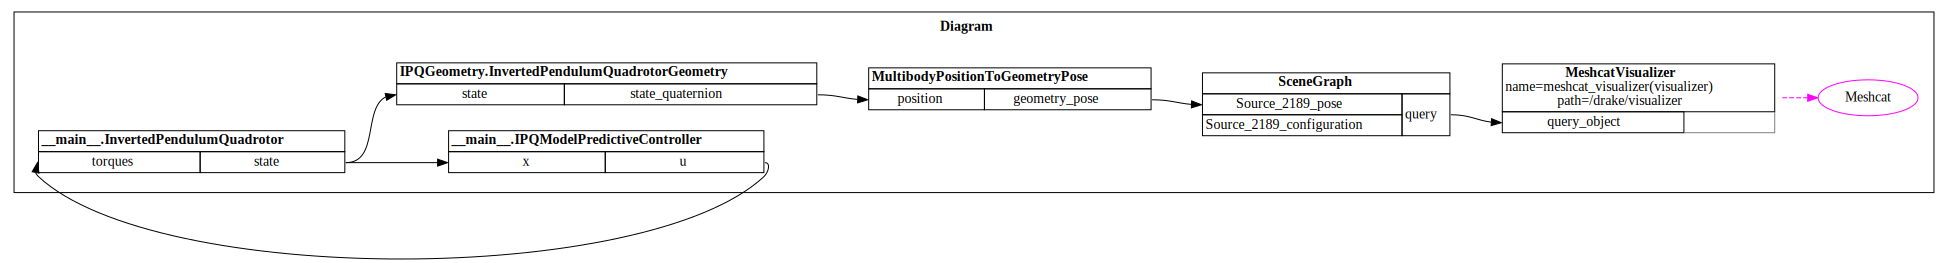

[[   1.29032258    1.29032258    1.29032258    1.29032258]
 [   0.          100.            0.         -100.        ]
 [ -60.            0.           60.            0.        ]
 [   7.           -7.            7.           -7.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]]
[0.12250897 0.12250897 0.12250897 0.12250897]
[[   1.29032258    1.29032258    1.29032258    1.29032258]
 [   0.          100.            0.         -100.        ]
 [ -60.            0.           60.            0.        ]
 [   7.           -7.            7.           -7.        ]
 [   0.            0.            0.            0.        ]
 [   0.            0.            0.            0.        ]]
[0.12249733 0.12249733 0.12249733 0.12249733]
[[   1.29032258    1.29032258    1.29032258    1.29032258]
 [   0.          100.            0.         -100.        ]
 [ -60.            0.           60.            0.        ]
 [   7.           -7.

In [72]:
def quadrotor_example():

    builder = DiagramBuilder()

    plant = builder.AddSystem(InvertedPendulumQuadrotor())

    # controller = builder.AddSystem(StabilizingLQRController(plant, [0, 0, 1]))
    # builder.Connect(controller.get_output_port(0), plant.get_input_port(0))
    # builder.Connect(plant.get_output_port(0), controller.get_input_port(0))

    # Set up visualization in MeshCat
    scene_graph = builder.AddSystem(SceneGraph())
    
    # unit_torque = builder.AddSystem(ConstantVectorSource([2, 2, 2, 2]))
    # multiplexer = builder.AddSystem(Multiplexer([12,2]))
    # builder.Connect(plant.get_output_port(0), multiplexer.get_input_port(0))
    # builder.Connect(pplant.get_output_port(0), multiplexer.get_input_port(1))
    R = np.eye(4);
    Q = np.diag([30, 30, 10, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]);
    Qf = Q;

    MPC = builder.AddSystem(IPQModelPredictiveController(Q, R, Qf))
    
    builder.Connect(MPC.get_output_port(0), plant.get_input_port(0))
    builder.Connect(plant.get_output_port(0), MPC.get_input_port(0))
    IPQGeometry.InvertedPendulumQuadrotorGeometry.AddToBuilder(builder, plant.get_output_port(0), scene_graph)
    meshcat.Delete()
    meshcat.ResetRenderMode()
    #MeshcatVisualizerCpp.AddToBuilder(builder, scene_graph, meshcat)
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    # end setup for visualization

    # AddDefaultVisualization(builder=builder, meshcat=meshcat)

    diagram = builder.Build()

    display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

    # Set up a simulator to run this diagram
    simulator = Simulator(diagram)
    simulator.set_target_realtime_rate(1.0)
    context = simulator.get_mutable_context()


    context.SetTime(0.)

    state = np.zeros(16,)
    state[1] = +1
    # state[4] = +0.4
    # state[6] = -0.01
    context.SetContinuousState(state)
    simulator.Initialize()
    simulator.AdvanceTo(10.0)

quadrotor_example()

In [ ]:
# Constants 

M = 0.5            # Weight of quadrotor
L = 0.565          # Length of pendulum to center of mass
l = 0.17           # Length of quadrotor wings
I = np.array([[0.0015, 0, 0], 
                [0, 0.0025, 0], 
                [0, 0, 0.0035]])

plant = InvertedPendulumQuadrotor(M, L, I, l)

In [ ]:
# First we'll choose one of Drake's example model files, a KUKA iiwa arm.
skydio = (
    "res/quadrotor.urdf")
pendulum = (
    "res/Pendulum.urdf"
)

meshcat.Delete()
# meshcat.DeleteAddedControls()

builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(
    builder, time_step=0.0005)
parser = Parser(plant)

# # Create a model visualizer and add the robot arm.
# # visualizer = ModelVisualizer(meshcat=meshcat)
quadrotor_instance = parser.AddModels(skydio)
parser.AddModels(pendulum)

pendulum_base_frame = plant.GetFrameByName("base")
quadrotor_base_link = plant.GetFrameByName("base_link")
# # plant.WeldFrames(plant.world_frame(), quadrotor_base_link)
plant.WeldFrames(quadrotor_base_link, pendulum_base_frame, X_FM=xyz_rpy_deg([0, 0, 0.03], [0, 180, 0]),)
# # plant.WeldFrames(plant.world_frame(), pendulum_base_frame, X_FM=xyz_rpy_deg([0, 0, 0], [0, 180, 0]),)
# plant.WeldFrames(quadrotor_base_link, pendulum_base_frame)
plant.Finalize()

quad_plant = builder.AddSystem(QuadrotorPlant())
#plant.AddToBuilder(builder, quad_plant.get_output_port(0), scene_graph)

quadrotor_body = plant.GetBodyByName("base_link")
plant.SetDefaultFreeBodyPose(quadrotor_body, xyz_rpy_deg([0, 0, 0.5], [0, 0, 0]))

n_q = plant.num_positions()

# zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_q + n_v)))
# builder.Connect(quad_plant.get_output_port(), plant.get_state_output_port(quadrotor_instance[0]))

# Add visualization to see the geometries.
AddDefaultVisualization(builder=builder, meshcat=meshcat)
# Start the interactive visualizer.
# Click the "Stop Running" button in MeshCat when you're finished.
diagram = builder.Build()
simulator = Simulator(diagram)

simulator.Initialize()
simulator.set_target_realtime_rate(1.)

# plant_context = diagram.GetMutableSubsystemContext(
#     plant, simulator.get_mutable_context())

# plant.SetFreeBodyPose(plant_context, quadrotor_body, xyz_rpy_deg([0, 0, 0.5], [0, 0, 0]))

display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))

#simulator.AdvanceTo(2.0)

# print(plant.get_state_output_port())
# print(plant.get_actuation_input_port())

In [8]:
print(dir(plant))

NameError: name 'plant' is not defined

###### print(dir(plant.get_input_port(0)))
print(plant.get_input_port(5).get_name())
print(dir(plant.get_desired_state_input_port(quadrotor_instance[0])))
print(plant.GetPositionNames())

In [151]:
print(dir(plant.get_state_output_port()))
print(plant.get_state_output_port().size()) 
# print(plant.get_state_input_port().size()) 
print(dir(plant.get_desired_state_input_port(quadrotor_instance[0]))) 
print(plant.GetVelocityNames())
print(plant.get_input_port(1).size())
print(plant.num_velocities())

['Allocate', 'Eval', 'EvalAbstract', 'EvalBasicVector', '__class__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_pybind11_del_orig', 'cache_entry', 'disable_caching_by_default', 'get_data_type', 'get_index', 'get_name', 'get_system', 'size']
19
['Allocate', 'Eval', 'EvalAbstract', 'EvalBasicVector', 'FixValue', 'GetFullDescription', 'HasValue', '__class__', '__del__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '_pybind11_del_orig'

In [6]:
import math

import matplotlib.pyplot as plt
import numpy as np
import pydot
from IPython.display import HTML, SVG, Latex, display
from pydrake.all import (AddMultibodyPlantSceneGraph, ConstantVectorSource,
                         DiagramBuilder, FirstOrderTaylorApproximation,
                         LinearQuadraticRegulator, MatrixGain,
                         MeshcatVisualizer, MultibodyPlant, Parser,
                         Saturation, SceneGraph, Simulator, StartMeshcat,
                         WrapToSystem)
from pydrake.common.containers import namedview
# from pydrake.examples.acrobot import (AcrobotGeometry, AcrobotInput,
#                                       AcrobotPlant, AcrobotState)
# from pydrake.examples.quadrotor import (QuadrotorGeometry, QuadrotorPlant,
#                                         StabilizingLQRController)
# from pydrake.solvers.mathematicalprogram import MathematicalProgram, Solve

# from underactuated import FindResource, running_as_notebook
# from underactuated.jupyter import ToLatex
# from underactuated.meshcat_cpp_utils import MeshcatSliders
# from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

PortDataType.kVectorValued


TypeError: DeclareAbstractOutputPort(): incompatible function arguments. The following argument types are supported:
    1. (self: pydrake.systems.framework.LeafSystem, name: str, alloc: Callable[[], pydrake.common.value.AbstractValue], calc: Callable[[pydrake.systems.framework.Context, pydrake.common.value.AbstractValue], None], prerequisites_of_calc: set[pydrake.systems.framework.DependencyTicket] = {DependencyTicket(15)}) -> pydrake.systems.framework.OutputPort

Invoked with: <__main__.InvertedPendulumQuadrotorGeometry object at 0x7af5d4040710>, 'geometry_pose', <bound method InvertedPendulumQuadrotorGeometry.output_geometry_pose of <__main__.InvertedPendulumQuadrotorGeometry object at 0x7af5d4040710>>